In [1]:
import torch
import sys
import os
sys.path.append('../vega/')
import vega
import scanpy as sc
import scvi
from scipy import sparse
import numpy as np
import gseapy as gp
import pandas as pd
torch.manual_seed(0)
np.random.seed(0)

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
path_to_save = '../paper/figures/organoid_vega/'
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)
font = {'family' : 'Arial',
        'size'   : 14}
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
# Scanpy figures params
sc.set_figure_params(dpi_save=300)
sc.settings.figdir = path_to_save

In [2]:
model = vega.VEGA.load('../trained_models/organoid_vega/')
print(model)

Using masked decoder
Constraining decoder to positive weights
Model successfully loaded.
VEGA model with the following parameters: 
n_GMVs: 682, dropout_rate:0.5, z_dropout:0.5, beta:0.0001, positive_decoder:True
Model is trained: True


In [3]:
# Make names prettier
model.adata.uns['_vega']['gmv_names'] = np.array([' '.join(i.split('_')[1:]) if 'REACTOME' in i else i for i in model.adata.uns['_vega']['gmv_names']])
gmv_names = model._get_gmv_names()

In [4]:
model.adata.obsm['X_vega'] = model.to_latent(return_mean=True)
sc.pp.neighbors(model.adata, use_rep='X_vega', n_neighbors=15)
sc.tl.umap(model.adata, min_dist=0.5, random_state=42)

In [5]:
embedding = model.adata.obsm['X_umap']

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


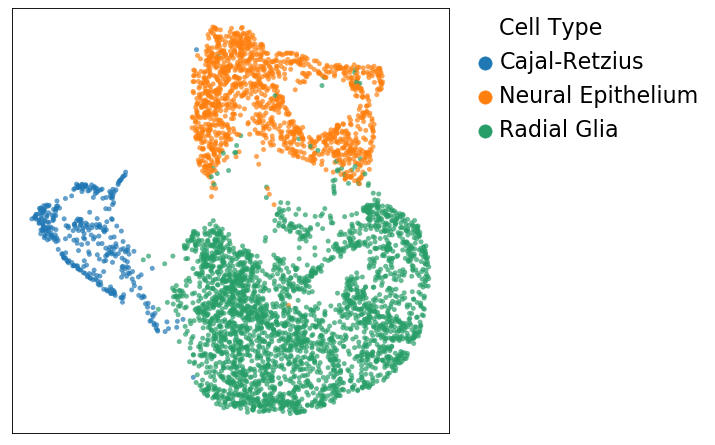

In [6]:
#sc.pl.umap(model.adata, color='Cell type')
umap_df = pd.DataFrame({'UMAP-1':embedding[:,0], 'UMAP-2':embedding[:,1],
                        'Cell Type':model.adata.obs['Cell type']})
fig, ax = plt.subplots(figsize=[7,7])
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cell Type', data=umap_df,
                linewidth=0, alpha=0.7, s=20, ax=ax, rasterized=True, hue_order=model.adata.obs['Cell type'].cat.categories)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
#plt.legend(frameon=False, ncol=1, fontsize=13, markerscale=1.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('')
ax.set_xlabel('')
plt.grid(False)
#plt.savefig(path_to_save+'umap_ct.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


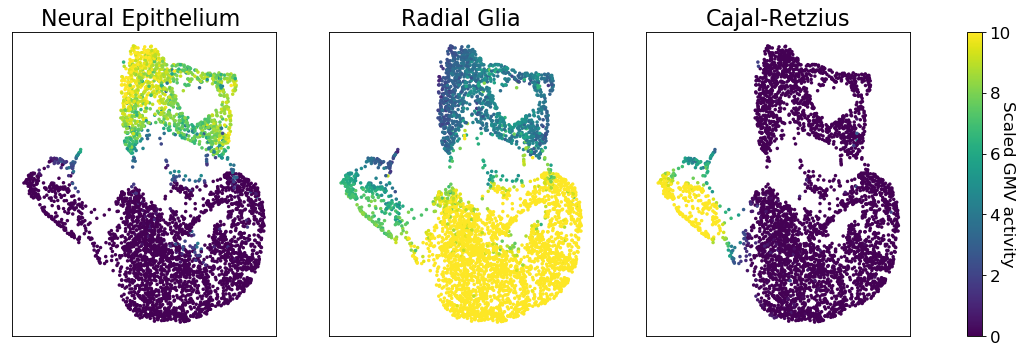

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

fig, ax = plt.subplots(1,3, figsize=[18,5])
ct = ['Neuroepithelium ', 'Radial Glia Cells', 'Cajal-Retzius Neurons']
lbl = ['Neural Epithelium ', 'Radial Glia', 'Cajal-Retzius']

cmap = cm.get_cmap('viridis')
normalizer=Normalize(0,10)
im=cm.ScalarMappable(norm=normalizer)

for i in range(len(ct)):
    im = ax[i].scatter(model.adata.obsm['X_umap'][:,0], model.adata.obsm['X_umap'][:,1], alpha = 1, linewidths=0,
                c = model.adata.obsm['X_vega'][:, gmv_names.index(ct[i])],
                       marker='o', s=10, cmap =cmap, norm=normalizer, rasterized=True)
    ax[i].set_title(lbl[i], fontsize=20)
    ax[i].set_xlabel('', fontsize=20)
    ax[i].set_ylabel('', fontsize=20)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
cbar = fig.colorbar(im, ax=ax.ravel().tolist())
cbar.ax.set_ylabel('Scaled GMV activity', rotation=270, fontsize=15)
cbar.ax.tick_params(labelsize=15)

#plt.savefig(path_to_save+'umap_marker_activity.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
# Differential gene expression
model.differential_activity(groupby='Cell type', n_permutations=10000, n_samples=5000, random_seed=0)

Using VEGA's adata attribute for differential analysis
No reference group: running 1-vs-rest analysis for .obs[Cell type]


In [9]:
mat_bf = np.zeros((3,3))
ct_list = list(model.adata.obs['Cell type'].unique())
ct_list.sort()
lbl = ['Neuroepithelium ', 'Radial Glia Cells', 'Cajal-Retzius Neurons']
map_lbl = {'Neuroepithelium ':'Neural Epithelium', 'Radial Glia Cells':'Radial Glia', 'Cajal-Retzius Neurons':'Cajal-Retzius'}
new_lbl = [map_lbl[i] for i in lbl]
lbl.sort()
new_lbl.sort()
for i, ct_1 in enumerate(ct_list):
    for j, ct_2 in enumerate(lbl):
        mat_bf[i,j] = model.adata.uns['_vega']['differential'][ct_1+' vs.rest']['bayes_factor'][gmv_names.index(ct_2)]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


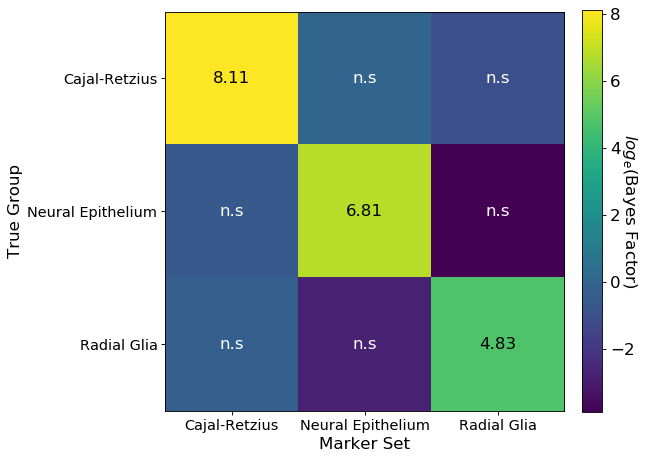

In [10]:
plt.figure(figsize=[7,7])
im = plt.imshow(mat_bf)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'$log_e$(Bayes Factor)', rotation=270, fontsize=15)
cbar.ax.tick_params(labelsize=15)
plt.xticks([0,1,2], new_lbl, fontsize=13)
plt.yticks([0,1,2], ct_list, fontsize=13)
for (j,i),label in np.ndenumerate(mat_bf):
    c = 'white' if label < 1. else 'black'
    label = label if label > 3 else 'n.s'
    if type(label) != str:
        label = '%.2f'%(label)
    plt.text(i,j,label,ha='center',va='center', fontsize=15, color=c)

plt.xlabel('Marker Set', fontsize=15)
plt.ylabel('True Group', fontsize=15)
plt.grid(False)
#plt.savefig(path_to_save+'ct_heatmap.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

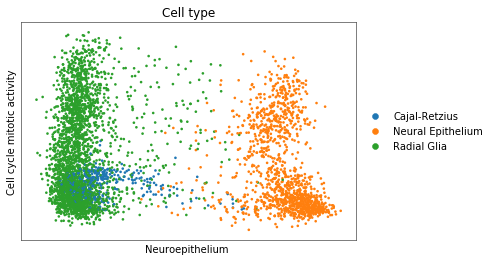

In [20]:
vega.plotting.gmv_plot(model.adata, x='Neuroepithelium ', y='Cell cycle mitotic activity', color='Cell type')

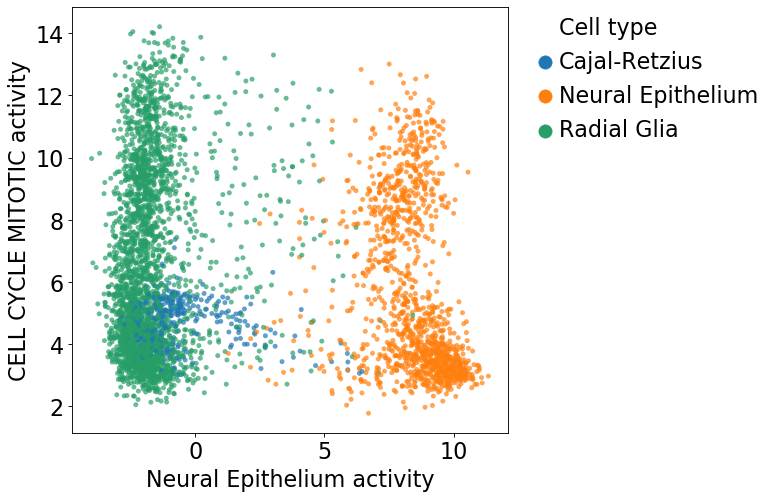

In [12]:
fig, ax = plt.subplots(figsize=[7,7])
x = model.adata.obsm['X_vega'][:, gmv_names.index('Neuroepithelium ')]
y = model.adata.obsm['X_vega'][:, gmv_names.index('CELL CYCLE MITOTIC')]
sns.scatterplot(x=x,
            y=y,
            hue=model.adata.obs['Cell type'],
            linewidth=0, alpha=0.7, s=20, ax=ax, rasterized=True,
            hue_order = model.adata.obs['Cell type'].cat.categories)
plt.ylabel('CELL CYCLE MITOTIC activity',fontsize=20)
plt.xlabel('Neural Epithelium activity',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.tick_params(labelsize=20)
plt.grid(False)
#plt.savefig(path_to_save+'bivar_cellcycle_ne.pdf', format='pdf', dpi=300, bbox_inches='tight')

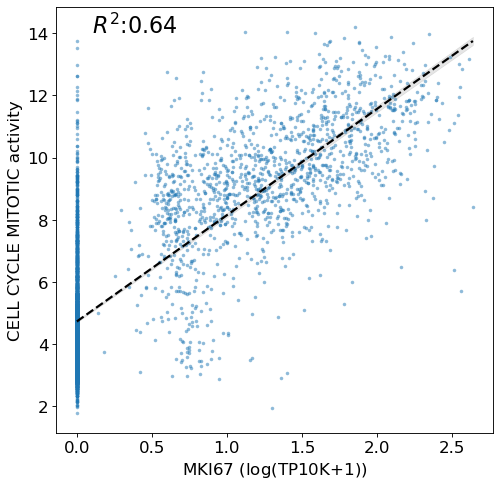

In [13]:
from scipy.stats import linregress
import seaborn as sns
fig, ax = plt.subplots(figsize=[7,7])
x = model.adata.X.A[:,model.adata.var.index.tolist().index('MKI67')]
y = model.adata.obsm['X_vega'][:, gmv_names.index('CELL CYCLE MITOTIC')]
l = np.linspace(np.min(x), np.max(x), 1000)
ax.scatter(x,
           y,
           s=10,
           alpha=0.5, linewidth=0, rasterized=True)
res = linregress(x, y)
m, b, corr, p, m_std= res
b_std = res.intercept_stderr
ax.plot(l, m*l+b, linestyle='--', color='k', linewidth=2)
ax.fill_between(l, (m-m_std)*l + (b-b_std), ((m+m_std)*l + (b+b_std)), alpha=0.1, color='k')


plt.text(0.1, 14, r'$R^2$:%.2f'%(corr**2), fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'MKI67 ($\log$(TP10K+1))', fontsize=15)
plt.ylabel('CELL CYCLE MITOTIC activity', fontsize=15)
plt.grid(False)
#plt.savefig(path_to_save+'corr_mki67_cellcycle.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

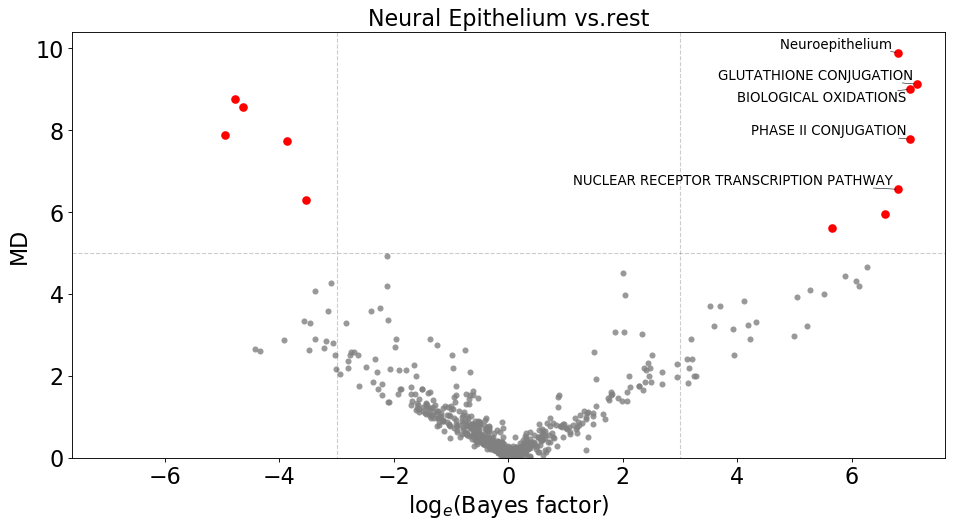

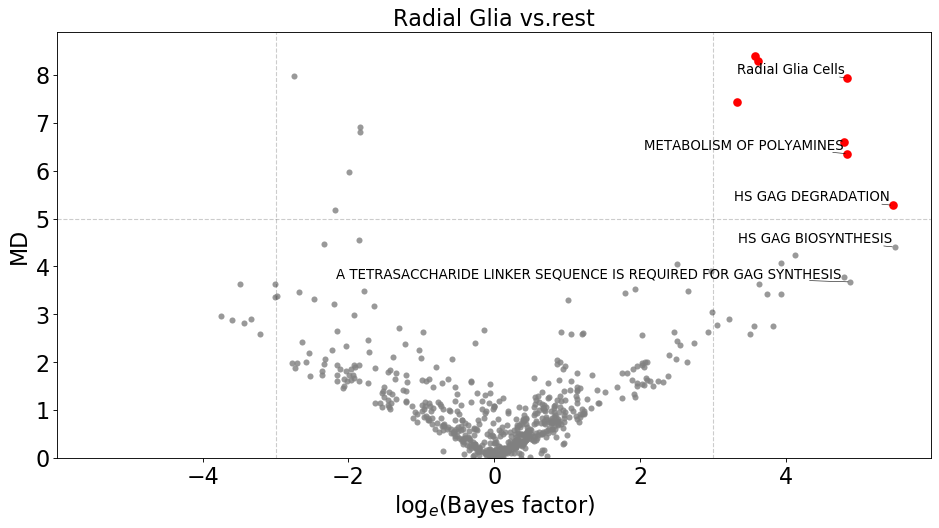

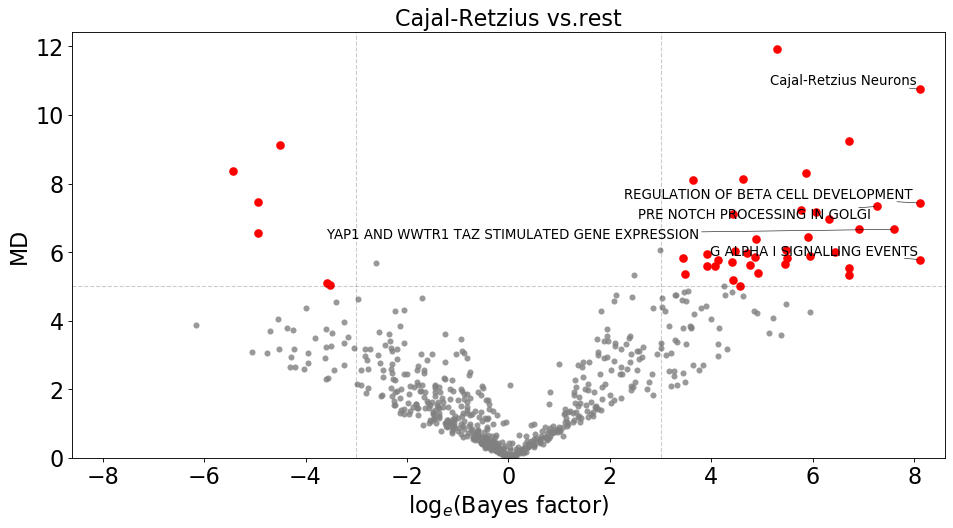

In [16]:
to_annotate = model.adata.uns['_vega']['differential']['Neural Epithelium vs.rest']['bayes_factor']
to_annotate = model.adata.uns['_vega']['gmv_names'][np.argsort(to_annotate)[::-1]][:5]
vega.plotting.volcano(model.adata,
                      group1='Neural Epithelium',
                      group2='rest',
                      annotate_gmv=list(to_annotate),#['Neuroepithelium '],
                      figsize=[14,7], s=30, fontsize=20,textsize=12,
                      title='Neural Epithelium vs.rest', sig_lvl=3, metric_lvl=5,
                      save=path_to_save+'ne_vs_rest.pdf')
to_annotate = model.adata.uns['_vega']['differential']['Radial Glia vs.rest']['bayes_factor']
to_annotate = model.adata.uns['_vega']['gmv_names'][np.argsort(to_annotate)[::-1]][:5]
vega.plotting.volcano(model.adata,
                      group1='Radial Glia',
                      group2='rest',
                      annotate_gmv=list(to_annotate),#['Radial Glia Cells'],
                      figsize=[14,7], s=30, fontsize=20,textsize=12,
                      title='Radial Glia vs.rest', sig_lvl=3, metric_lvl=5,
                      save=path_to_save+'rg_vs_rest.pdf')
to_annotate = model.adata.uns['_vega']['differential']['Cajal-Retzius vs.rest']['bayes_factor']
to_annotate = model.adata.uns['_vega']['gmv_names'][np.argsort(to_annotate)[::-1]][:5]
vega.plotting.volcano(model.adata,
                      group1='Cajal-Retzius',
                      group2='rest',
                      annotate_gmv=list(to_annotate),#['Cajal-Retzius Neurons'],
                      figsize=[14,7], s=30, fontsize=20,textsize=12,
                      title='Cajal-Retzius vs.rest', sig_lvl=3, metric_lvl=5,
                      save=path_to_save+'cr_vs_rest.pdf')

In [32]:
#  Save top 100 DA GMV for each cell type
dict_top100 = {(i,j):[] for i in map_lbl.values() for j in ['name','logBF']}
for k in dict_top100.keys():
    ct = k[0]
    t = k[1]
    s_idx = np.argsort(np.abs(model.adata.uns['_vega']['differential'][ct + ' vs.rest']['bayes_factor']))[::-1][:100]
    if t=='logBF':
        dict_top100[k] = model.adata.uns['_vega']['differential'][ct + ' vs.rest']['bayes_factor'][s_idx]
    else:
        names = np.array(gmv_names)[s_idx]
        for orig_ct in map_lbl.keys():
            if np.where(names==orig_ct)[0].size != 0:
                idx = np.where(names==orig_ct)[0][0]
                names[idx] = map_lbl[orig_ct]
        dict_top100[k] = names
df_top100 = pd.DataFrame(dict_top100)
#df_top100.to_csv('../supp_data/suppTable_top100DF_organoid.csv', sep=',', index=True, header=True)